In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



In [2]:
#Libraries
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from math import sqrt


In [3]:
#Reading the data one by one and assigning it to one dataframe

data = {"fifa_15": pd.read_csv("https://raw.githubusercontent.com/Saraman04/fifa20/main/data/players_15.csv"),
        "fifa_16": pd.read_csv("https://raw.githubusercontent.com/Saraman04/fifa20/main/data/players_16.csv"),
        "fifa_17": pd.read_csv("https://raw.githubusercontent.com/Saraman04/fifa20/main/data/players_17.csv"),
        "fifa_18": pd.read_csv("https://raw.githubusercontent.com/Saraman04/fifa20/main/data/players_18.csv"),
        "fifa_19": pd.read_csv("https://raw.githubusercontent.com/Saraman04/fifa20/main/data/players_19.csv"),
        "fifa_20": pd.read_csv("https://raw.githubusercontent.com/Saraman04/fifa20/main/data/players_20.csv")}

#Adding new column Year
for key in data:
    data[key]["year"] = 2000 + eval(key.split("_")[-1])
    
data_year = pd.DataFrame().append([data[year] for year in data])


In [4]:
#Since overall score claculates for all skills, we will be basing the entire club score only on that

#Selecting the appropriate columns
col = ['sofifa_id','club','overall','year']
data_year= data_year[col]
data_year

,sofifa_id,club,overall,year
0,158023,FC Barcelona,93,2015
1,20801,Real Madrid,92,2015
2,9014,FC Bayern München,90,2015
3,41236,Paris Saint-Germain,90,2015
4,167495,FC Bayern München,90,2015
...,...,...,...,...
18273,245006,Beijing Renhe FC,48,2020
18274,250995,Shanghai SIPG FC,48,2020
18275,252332,Hebei China Fortune FC,48,2020
18276,251110,Shanghai Greenland Shenhua FC,48,2020


In [5]:
#Grouping data so that it makes easier to track how a player improved over the years when he was in a particular club
#Dropping players who haven't completed a year in club

grouped_data = (data_year.groupby(["club", "sofifa_id"]).filter(lambda x : x.shape[0]>1)).groupby(["club", "sofifa_id"])

#Every subframe of group data contains a player's history in that club
grouped_data.get_group(("Real Madrid", 20801))

,sofifa_id,club,overall,year
1,20801,Real Madrid,92,2015
1,20801,Real Madrid,93,2016
0,20801,Real Madrid,94,2017
0,20801,Real Madrid,94,2018


In [6]:
#Grouping players based on clubs
groups, ids = zip(*grouped_data.groups)
player_by_club = {grp : [] for grp in set(groups)}
for i in range(len(ids)):
    player_by_club[groups[i]].append(ids[i])


In [7]:
#Selecting clubs in the leagues we are interested in
required_clubs = {'Manchester City', 'Arsenal','Tottenham Hotspur','Leicester City','Manchester United',
                   'Southampton','West Ham United','Liverpool','Chelsea','Everton','Watford','Crystal Palace',
                   'Bournemouth','FC Bayern München','Borussia Dortmund','Bayer 04 Leverkusen','Borussia Mönchengladbach',
                   'FC Schalke 04','1. FSV Mainz 05','Hertha BSC','VfL Wolfsburg','FC Augsburg','SV Werder Bremen',
                   'TSG 1899 Hoffenheim','Paris Saint-Germain','Olympique Lyonnais','AS Monaco','OGC Nice','LOSC Lille',
                   'AS Saint-Étienne','Stade Rennais FC','Angers SCO','FC Girondins de Bordeaux','Montpellier HSC'
                   'Olympique de Marseille','FC Nantes','FC Barcelona','Real Madrid','Atlético Madrid','Villarreal CF',
                   'Athletic Club de Bilbao','RC Celta','Sevilla FC','Real Sociedad','Real Betis','Valencia CF','RCD Espanyol',
                   'SD Eibar','Juventus','Napoli','Roma','Inter','Fiorentina','Sassuolo','Milan','Lazio','Genoa','Torino',
                   'Atalanta','Bologna','Sampdoria','Udinese','Montpellier HSC','Olympique de Marseille'}

player_by_club = {key: player_by_club[key] for key in player_by_club.keys() & required_clubs  }


****
**** We have only considered Overall score of players to calculate the club score. The reason for this is, overall scores are calculated by domain experts to include all other factors and should be able to track any change in player. Focusing too minutely on other scores will be redundant and would be akin to overfitting. The value and wage of players does not say much about player skill improvement as seen in EDA, hence we have not considereed that aswell.****
****

In [8]:
#Over all clubs
club_performance = pd.DataFrame(columns=['overall'])
for club in player_by_club:
    
    player_performance = pd.DataFrame(columns=['overall'])
    #Over all players
    for player in player_by_club[club]:
        subframe = grouped_data.get_group((club, player))['overall']
        
        #Over all years
        #Differece in overall skill stats over years
        for i in range(subframe.shape[0]-1):
            if (i):
                #cum_sum is difference in overall skill over years summed
                cum_sum+=subframe.iloc[i+1]-subframe.iloc[i]
            else:
                cum_sum=subframe.iloc[i+1]-subframe.iloc[i]
                
        #average increase or decrease in overall skill points over years
        cum_sum /= (subframe.shape[0]-1)
        player_performance.loc[player] = cum_sum
    
    #Storing Median increase/decrease in overall skill points as per club
    club_performance.loc[club] = player_performance.median()
    
club_performance.head()

,overall
FC Nantes,1.50
Roma,0.00
RC Celta,1.75
Real Betis,1.50
Chelsea,0.50


In [9]:
#Scalaing the skills between 0 and 100, 0 for the lowest club and 100 for highest clubs

x_scaled = (club_performance['overall']-club_performance['overall'].min())/(club_performance['overall'].max()-club_performance['overall'].min())
club_score = x_scaled*100

new_df = pd.DataFrame({'clubs':club_performance.index, 'score':(club_score.values).flatten()})

new_df.head()

,clubs,score
0,FC Nantes,75.0
1,Roma,0.0
2,RC Celta,87.5
3,Real Betis,75.0
4,Chelsea,25.0


No handles with labels found to put in legend.


<function matplotlib.pyplot.show(close=None, block=None)>

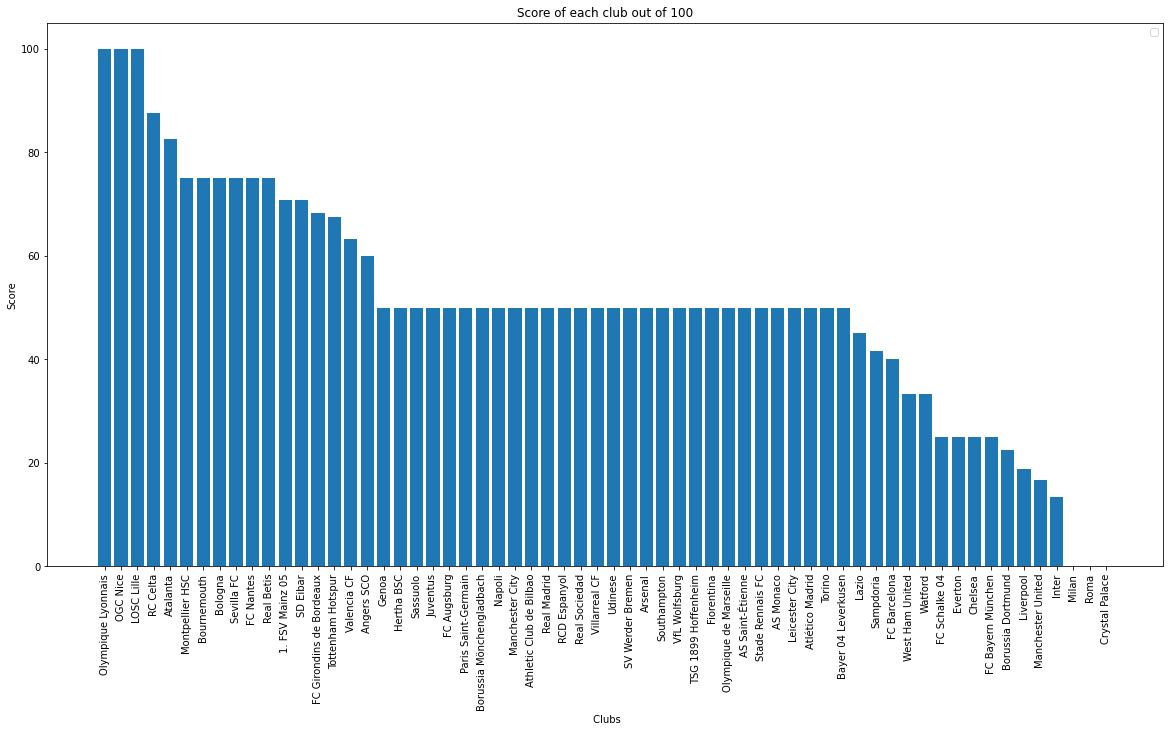

In [10]:
#Sorting the dataframe based on score
sorted_df = new_df.sort_values(['score'], ascending=False, inplace=False)

#Plotting the scores of the clubs
plt.figure(figsize=(20,10))
plt.bar(sorted_df['clubs'].values , sorted_df['score'].values )
plt.legend(loc='upper right')
plt.title('Score of each club out of 100')
plt.xlabel(' Clubs')
plt.ylabel('Score')
plt.xticks(rotation=90)

plt.show

In [11]:
#Printing the top 3 clubs
print ('Rank of clubs according to scores \n\n')
for i, club in enumerate(new_df.clubs):
    if (i==3):
        break
    print(f"{i+1}. {club}")

Rank of clubs according to scores 


1. FC Nantes
2. Roma
3. RC Celta


In [12]:
#Outputing the dataframe as a csv file to share with other teams
#new_df.to_csv(r'output\club_score.csv', index = False)

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(close=None, block=None)>

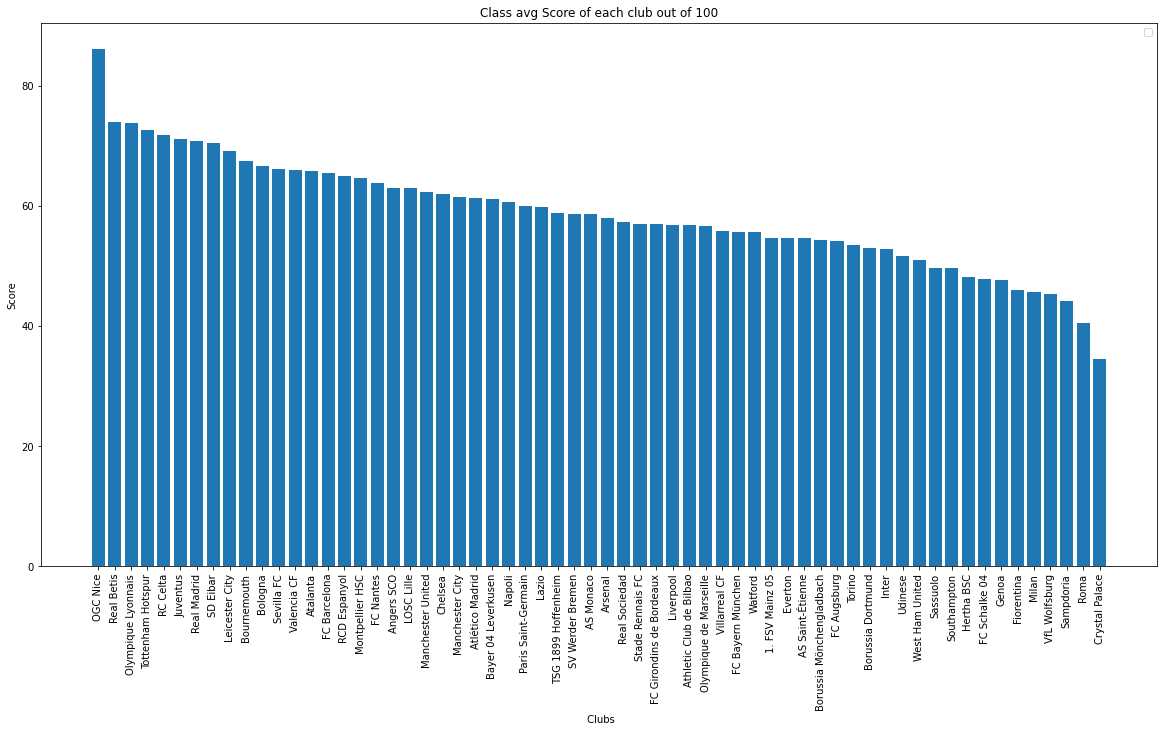

In [13]:
#Reading and plotting avg scores other batch teams have given to each club

df_class_avg = pd.read_csv("https://raw.githubusercontent.com/Saraman04/fifa20/main/data/Class_avg_club_score.csv")

#Sorting the dataframe based on score
sorted_df_class_avg = df_class_avg.sort_values(['score'], ascending=False, inplace=False)

#Plotting the Class avg Score of the clubs
plt.figure(figsize=(20,10))
plt.bar(sorted_df_class_avg['clubs'].values , sorted_df_class_avg['score'].values )
plt.legend(loc='upper right')
plt.title('Class avg Score of each club out of 100')
plt.xlabel(' Clubs')
plt.ylabel('Score')
plt.xticks(rotation=90)

plt.show

In [14]:
#Sorting our club score and class avg score alphabetically for further comparison

alpsort_new_df = new_df.sort_values(by=['clubs'], inplace=False, ascending=True)
alpsort_df_class_avg = df_class_avg.sort_values(by=['clubs'], inplace=False, ascending=True)

#Rmse between our score and class average
print("Rmse between our score and class average is : %.3f" %( sqrt(mean_squared_error(alpsort_new_df.score.values , alpsort_df_class_avg.score.values))))

Rmse between our score and class average is : 19.127


No handles with labels found to put in legend.


<function matplotlib.pyplot.show(close=None, block=None)>

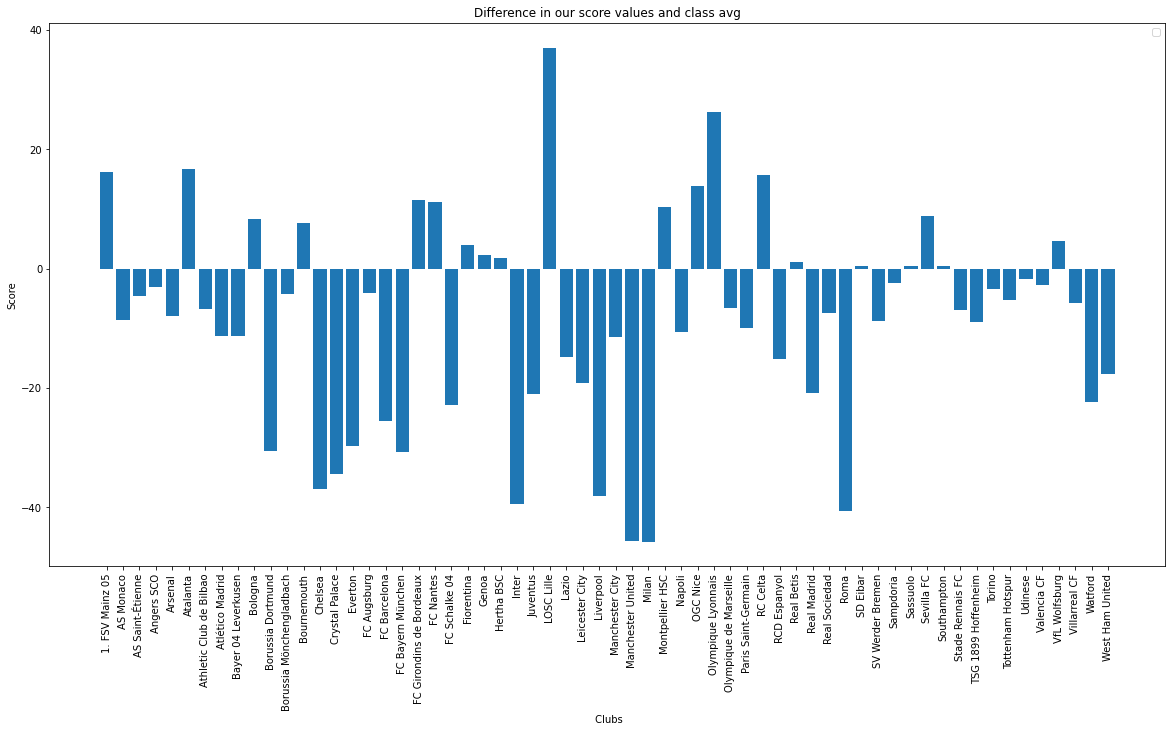

In [15]:
#Difference in score values and class avg
difference = alpsort_new_df.score.values - alpsort_df_class_avg.score.values

#Plotting the score difference of the clubs
plt.figure(figsize=(20,10))
plt.bar(alpsort_new_df['clubs'].values , difference )
plt.legend(loc='upper right')
plt.title('Difference in our score values and class avg')
plt.xlabel(' Clubs')
plt.ylabel('Score')
plt.xticks(rotation=90)

plt.show

****
****The comparrision of our score and class avg doesn't hold any value other than being a fun experiment :D . We have checked other team RMSE as well
****